# Video Recognition

### Spatio-Temporal model, CNN+LSTM

220426

[ref](https://bleedai.com/human-activity-recognition-using-tensorflow-cnn-lstm/)

In [1]:
# Install the required libraries.
!pip install imageio==2.4.1
!pip install pafy youtube-dl moviepy
!pip uninstall -y pafy
!pip install git+https://github.com/Cupcakus/pafy

     |████████████████████████████████| 1.9 MB 8.6 MB/s 
Found existing installation: pafy 0.5.5
Uninstalling pafy-0.5.5:
  Successfully uninstalled pafy-0.5.5
  Cloning https://github.com/Cupcakus/pafy to /tmp/pip-req-build-rjzs92vc
  Running command git clone -q https://github.com/Cupcakus/pafy /tmp/pip-req-build-rjzs92vc
  Created wheel for pafy: filename=pafy-0.5.5-py2.py3-none-any.whl size=35757 sha256=c4c03e2ebc5528bbf19252e51098f1bd5030f4574867cc267d43becc0d9c2d6c
  Stored in directory: /tmp/pip-ephem-wheel-cache-osqw4is3/wheels/93/1a/52/3c75e2f35b4aac122bcb0a64c08339224a76eafef3f150b9db
Successfully built pafy


In [2]:
## prepare data
!git clone https://github.com/airobotlab/lecture_4_video_recognition.git
!mkdir UCF50
%cd UCF50
!mkdir HorseRace
!mkdir Swing
!mkdir TaiChi
!mkdir WalkingWithDog
%cd ../
!mv lecture_4_video_recognition/*.zip ./UCF50

%cd UCF50
!unzip HorseRace.zip -d ./HorseRace
!unzip Swing.zip -d ./Swing
!unzip TaiChi.zip -d ./TaiChi
!unzip WalkingWithDog.zip -d ./WalkingWithDog
!rm -rf *.zip
%cd ..
!rm -rf lecture_4_video_recognition

# Discard the output of this cell.
# %%capture
# Downlaod the UCF50 Dataset
# !wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
#Extract the Dataset
# !unrar x UCF50.rar

Cloning into 'lecture_4_video_recognition'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 21 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), done.
/content/UCF50
/content
/content/UCF50
Archive:  HorseRace.zip
  inflating: ./HorseRace/v_HorseRace_g01_c01.avi  
  inflating: ./HorseRace/v_HorseRace_g01_c02.avi  
  inflating: ./HorseRace/v_HorseRace_g01_c03.avi  
  inflating: ./HorseRace/v_HorseRace_g01_c04.avi  
  inflating: ./HorseRace/v_HorseRace_g03_c01.avi  
  inflating: ./HorseRace/v_HorseRace_g03_c02.avi  
  inflating: ./HorseRace/v_HorseRace_g03_c03.avi  
  inflating: ./HorseRace/v_HorseRace_g03_c04.avi  
  inflating: ./HorseRace/v_HorseRace_g03_c05.avi  
  inflating: ./HorseRace/v_HorseRace_g04_c01.avi  
  inflating: ./HorseRace/v_HorseRace_g04_c02.avi  
  inflating: ./HorseRace/v_HorseRace_g04_c03.avi  
  inflating: ./HorseRace/v_HorseRace_g04_c04

In [3]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
 
from moviepy.editor import *
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import pickle

seed_constant = 220426
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1638400/45929032 bytes (3.6%)3940352/45929032 bytes (8.6%)5095424/45929032 bytes (11.1%)7356416/45929032 bytes (16.0%)9068544/45929032 bytes (19.7%)10567680/45929032 bytes (23.0%)12484608/45929032 bytes (27.2%)14974976/45929032 bytes (32.6%)17154048/45929032 bytes (37.3%)18718720/45929032 bytes (40.8%)20832256/45929032 bytes (45.4%)23240704/45929032 bytes (50.6%)24625

# Step 2: Preprocess the Dataset
    
Next, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range [0-1] by dividing the pixel values with 255, which makes convergence faster while training the network.

In [4]:
## config
epochs = 50
batch_size = 64

# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "UCF50"

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]
CLASSES_LIST_IDX = [all_classes_names.index(tmp) for tmp in CLASSES_LIST]

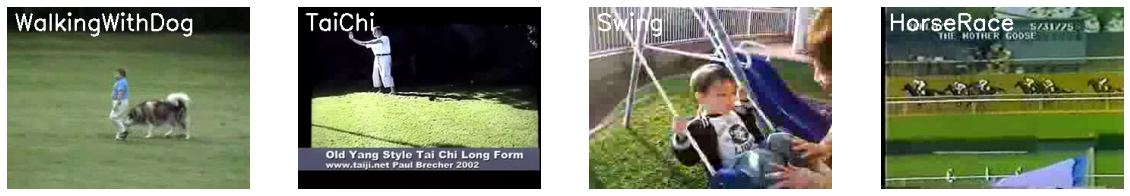

In [5]:
## visualize
plt.figure(figsize=(20, 20))

# Iterating through all the generated random values.
for idx, CLASS_IDX in enumerate(CLASSES_LIST_IDX):

    selected_class_Name = all_classes_names[CLASS_IDX]
#     print(idx, CLASS_IDX, selected_class_Name)
    
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(
        f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(1, 4, idx+1)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [6]:
# IMAGE_HEIGHT, IMAGE_WIDTH, SEQUENCE_LENGTH are key parameters
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''
 
    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)
 
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
 
        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
 
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Return the frames list.
    return frames_list

def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
 
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    print('make dataset done!')
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths


In [7]:
## make dataset
features, labels, video_files_paths = create_dataset()
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

with open('data.pickle', 'wb' ) as file:
    pickle.dump([features, labels, one_hot_encoded_labels, video_files_paths], file)

with open('data.pickle', 'rb' ) as file:
    features, labels, one_hot_encoded_labels, video_files_paths = pickle.load(file)    
print('data shape', features.shape)
print('\nlabel: %s'%labels)
# print(video_files_paths)

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace
make dataset done!
data shape (248, 20, 64, 64, 3)

label: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [8]:
## split dataset into train(75%)/test(25%)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, one_hot_encoded_labels, \
    test_size = 0.2, shuffle = True, \
    random_state = seed_constant)

print('train shape:', features_train.shape)
print('test shape:', features_test.shape)

train shape: (198, 20, 64, 64, 3)
test shape: (50, 20, 64, 64, 3)


In this step, we will implement the first approach by using a combination of ConvLSTM cells. A ConvLSTM cell is a variant of an LSTM network that contains convolutions operations in the network. it is an LSTM with convolution embedded in the architecture, which makes it capable of identifying spatial features of the data while keeping into account the temporal relation.
<img src='https://drive.google.com/uc?export=view&id=1KHN_JFWJoJi1xQj_bRdxy2QgevGOH1qP'>

For video classification, this approach effectively captures the spatial relation in the individual frames and the temporal relation across the different frames. As a result of this convolution structure, the ConvLSTM is capable of taking in 3-dimensional input (width, height, num_of_channels) whereas a simple LSTM only takes in 1-dimensional input hence an LSTM is incompatible for modeling Spatio-temporal data on its own.

# Step 4.1: Construct the Model
To construct the model, we will use Keras ConvLSTM2D recurrent layers. The ConvLSTM2D layer also takes in the number of filters and kernel size required for applying the convolutional operations. The output of the layers is flattened in the end and is fed to the Dense layer with softmax activation which outputs the probability of each action category.

We will also use MaxPooling3D layers to reduce the dimensions of the frames and avoid unnecessary computations and Dropout layers to prevent overfitting the model on the data. The architecture is a simple one and has a small number of trainable parameters. This is because we are only dealing with a small subset of the dataset which does not require a large-scale model.# 

In [9]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''
 
    # We will use a Sequential model for model construction
    model = Sequential()
 
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model


Now we will utilize the function create_convlstm_model() created above, to construct the required convlstm model.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

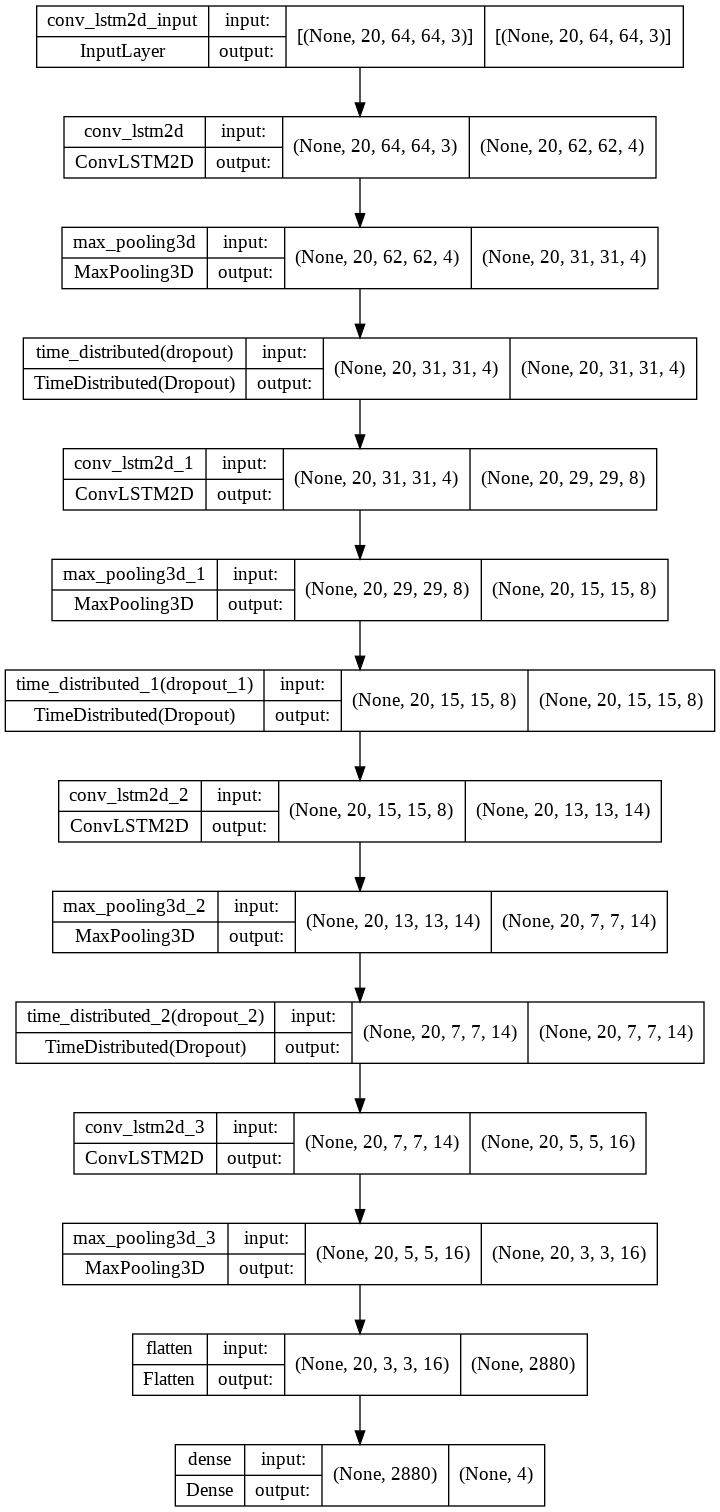

In [10]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()
 
# Display the success message. 
print("Model Created Successfully!")

# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)


# Step 4.2: Compile & Train the Model
Next, we will add an early stopping callback to prevent overfitting and start the training after compiling the model.

In [11]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

In [12]:
## train!
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, \
                                                     epochs = epochs, batch_size = batch_size, \
                                                     shuffle = True, validation_split = 0.2, \
                                                     callbacks = [early_stopping_callback])


Epoch 1/50
3/3 [==============================] - 30s 2s/step - loss: 1.3820 - accuracy: 0.3038 - val_loss: 1.3580 - val_accuracy: 0.3500
Epoch 2/50
3/3 [==============================] - 5s 2s/step - loss: 1.3235 - accuracy: 0.4241 - val_loss: 1.3182 - val_accuracy: 0.3000
Epoch 3/50
3/3 [==============================] - 5s 2s/step - loss: 1.2309 - accuracy: 0.3797 - val_loss: 1.3415 - val_accuracy: 0.4000
Epoch 4/50
3/3 [==============================] - 5s 2s/step - loss: 1.1943 - accuracy: 0.4430 - val_loss: 1.3612 - val_accuracy: 0.3750
Epoch 5/50
3/3 [==============================] - 5s 2s/step - loss: 1.1563 - accuracy: 0.4873 - val_loss: 1.2886 - val_accuracy: 0.3000
Epoch 6/50
3/3 [==============================] - 5s 2s/step - loss: 1.1381 - accuracy: 0.4873 - val_loss: 1.2665 - val_accuracy: 0.3250
Epoch 7/50
3/3 [==============================] - 5s 2s/step - loss: 1.1142 - accuracy: 0.4937 - val_loss: 1.2389 - val_accuracy: 0.4000
Epoch 8/50
3/3 [========================

In [13]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)


2/2 [==============================] - 1s 293ms/step - loss: 1.4597 - accuracy: 0.5200


In [14]:
## Save the Model
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
save_path = 'best_model_%.2f_%.2f.h5'%(model_evaluation_accuracy, model_evaluation_loss)

# Save Model
convlstm_model.save(save_path)

# Re load model
convlstm_model = load_model(save_path)

# Step 4.3: Plot Model’s Loss & Accuracy Curves
Now we will create a function plot_metric() to visualize the training and validation metrics. We already have separate metrics from our training and validation steps so now we just have to visualize them.

In [15]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
 
    # Add title to the plot.
    plt.title(str(plot_name))
 
    # Add legend to the plot.
    plt.legend()


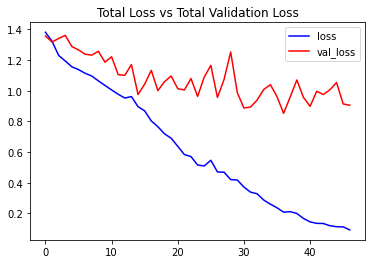

In [16]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

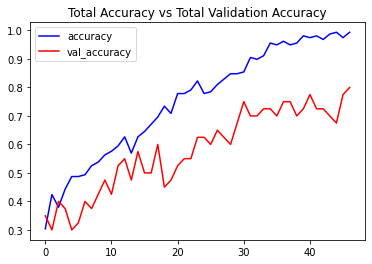

In [17]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

# Step 6: Test the Best Performing Model on YouTube videos
From the results, it seems that the LRCN model performed significantly well for a small number of classes. so in this step, we will put the LRCN model to test on some youtube videos.

Create a Function to Download YouTube Videos:
We will create a function download_youtube_videos() to download the YouTube videos first using pafy library. The library only requires a URL to a video to download it along with its associated metadata like the title of the video.

In [18]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''
 
     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)
 
     # Retrieve the title of the video.
     title = video.title
 
     # Get the best available quality object for the video.
     video_best = video.getbest()
 
     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'
 
     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)
 
     # Return the video title.
     return title


Download a Test Video:  
Now we will utilize the function download_youtube_videos() created above to download a youtube video on which the LRCN model will be tested.

In [19]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'


In [20]:
def predict_on_video(model, video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''
 
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
 
    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
 
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''
 
    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():
 
        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255
 
        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)
 
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:
 
            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = model.predict(np.expand_dims(frames_queue, axis = 0))[0]
 
            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)
 
            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]
 
        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
 
        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()


In [21]:
%%time
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
print(output_video_file_path)

# Perform Action Recognition on the Test Video.
predict_on_video(convlstm_model, input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

test_videos/Test Video-Output-SeqLen20.mp4
CPU times: user 1min 42s, sys: 2.22 s, total: 1min 45s
Wall time: 1min 44s


In [22]:
# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()


100%|██████████| 867/867 [00:02<00:00, 294.60it/s]


Create a Function To Perform a Single Prediction on Videos  
Now let’s create a function that will perform a single prediction for the complete videos. We will extract evenly distributed N (SEQUENCE_LENGTH) frames from the entire video and pass them to the LRCN model. This approach is really useful when you are working with videos containing only one activity as it saves unnecessary computations and time in that scenario.

In [23]:
def predict_single_action(model, video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''
 
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''
 
    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
 
    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Read a frame.
        success, frame = video_reader.read() 
 
        # Check if frame is not read properly then break the loop.
        if not success:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)
 
    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)
 
    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    # Release the VideoCapture object. 
    video_reader.release()

    return predicted_labels_probabilities

In [24]:
%%time

# Download the youtube video.
video_title = download_youtube_videos('https://youtu.be/fc3w827kwyA', test_videos_directory)
 
# Construct tihe nput youtube video path
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

# Perform Single Prediction on the Test Video.
predicted_labels_probabilities = predict_single_action(convlstm_model, input_video_file_path, SEQUENCE_LENGTH)


Action Predicted: HorseRace
Confidence: 0.3846387565135956
CPU times: user 1.81 s, sys: 262 ms, total: 2.07 s
Wall time: 1min 57s


In [ ]:
# Display the input video.
print(input_video_file_path)
VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display(maxduration=250)
